# Streaming output from agents

## Build agent

In [20]:
# import libraries
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image
from langchain_openai import ChatOpenAI

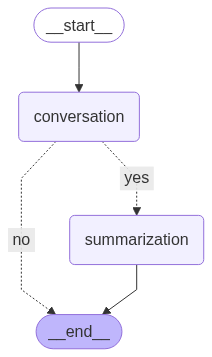

In [2]:
# Define state
class State(MessagesState):
    summary: str

# Instantiate llm
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Define conversation node
def conversation(state: State) -> State:
    summary = state.get("summary", "")
    messages = []
    if summary:
        system_message = f"Here is a summary of the conversation till date: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    return {"messages": llm.invoke(messages)}

# Define a summarization node
def summarization(state: State) -> State:
    summary = state.get("summary", "")
    if summary:
        summary_message = f"Here is a summary of the conversation till date: {summary}\n\nExtend this conversation by considering the messages above"
    else:
        summary_message = "Create a summary of the conversation above"
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    summary_response = llm.invoke(messages)
    messages_to_remove = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {
        "messages": messages_to_remove,
        "summary": summary_response.content
    }

# Define function to route to summarizer conditionally
def should_summarize(state: State) -> str:
    if len(state["messages"]) > 6:
        return "yes"
    else:
        return "no"
    
# Build graph
memory = MemorySaver()
graphBuilder = StateGraph(State)
graphBuilder.add_node("conversation", conversation)
graphBuilder.add_node("summarization", summarization)

graphBuilder.add_edge(START, "conversation")
graphBuilder.add_conditional_edges("conversation", should_summarize, {
        "yes": "summarization",
        "no": END
    })
graphBuilder.add_edge("summarization", END)

graph = graphBuilder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Steam graph state - Updates only

In [ ]:
# Get raw output
config = {"configurable": {"thread_id": 1}}

for chunk in graph.stream({"messages": [HumanMessage(content="Hello I am Arnab!")]}, config, stream_mode="updates"):
	print(chunk)

{'conversation': {'messages': AIMessage(content='Hello Arnab! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbtFDlpmtWCA6Dz3yFXeYjLa62rvl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9a84d3f7-f498-4084-9eb8-11890ab50174-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [6]:
# Get messages pretty printed
config = {"configurable": {"thread_id": 1}}

for chunk in graph.stream({"messages": [HumanMessage(content="Hello I am Arnab!")]}, config, stream_mode="updates"):
    chunk['conversation']['messages'].pretty_print()

================================== Ai Message ==================================

Hello again, Arnab! How can I help you today?


## Stream graph state - Full state values

In [7]:
# Get raw output
config = {"configurable": {"thread_id": 2}}

for event in graph.stream({"messages": [HumanMessage(content="Hello I am Arnab!")]}, config, stream_mode="values"):
    print(event)


{'messages': [HumanMessage(content='Hello I am Arnab!', additional_kwargs={}, response_metadata={}, id='6ad3d872-7a62-4d14-b1e1-fb96759f1385')]}
{'messages': [HumanMessage(content='Hello I am Arnab!', additional_kwargs={}, response_metadata={}, id='6ad3d872-7a62-4d14-b1e1-fb96759f1385'), AIMessage(content='Hello Arnab! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbtKhme95h0gRWhVr37VxI9OAzMxt', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--373bdf8f-dd2d-447e-abd3-1c7bbfd5c72b-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'tota

In [11]:
# Get messages prety printed
config = {"configurable": {"thread_id": 3}}

input_messages = [HumanMessage(content="How are you?!")]
for event in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("*" * 30)


================================ Human Message =================================

Hello I am Arnab!
================================== Ai Message ==================================

Hello Arnab! How can I assist you today?
================================ Human Message =================================

How are you?!
******************************
================================ Human Message =================================

Hello I am Arnab!
================================== Ai Message ==================================

Hello Arnab! How can I assist you today?
================================ Human Message =================================

How are you?!
================================== Ai Message ==================================

Thank you for asking! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?
******************************


## Stream tokens

In [ ]:
# Fetch raw token streaming output
config = {"configurable": {"thread_id": 4}}

input_messages = [HumanMessage(content="I love to play Grand Theft Auto!")]
async for event in graph.astream_events({"messages": input_messages}, config, version="v2"):
    print(f"Node:  {event["metadata"].get("langgraph_node", "")}, Type: {event["event"]}, Name: {event["name"]}")

Node:  , Type: on_chain_start, Name: LangGraph
Node:  conversation, Type: on_chain_start, Name: conversation
Node:  conversation, Type: on_chat_model_start, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat_model_stream, Name: ChatOpenAI
Node:  conversation, Type: on_chat

In [ ]:
# Fetch raw messages from LLM
config = {"configurable": {"thread_id": 6}}

input_messages = [HumanMessage(content="I love to play Grand Theft Auto!")]
async for event in graph.astream_events({"messages": input_messages}, config, version="v2"):
    if event["metadata"].get("langgraph_node", "") == "conversation" and event["event"] == "on_chat_model_stream":
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--625d4c07-3fdc-4355-8422-a87a352b3851')}
{'chunk': AIMessageChunk(content="That's", additional_kwargs={}, response_metadata={}, id='run--625d4c07-3fdc-4355-8422-a87a352b3851')}
{'chunk': AIMessageChunk(content=' great', additional_kwargs={}, response_metadata={}, id='run--625d4c07-3fdc-4355-8422-a87a352b3851')}
{'chunk': AIMessageChunk(content='!', additional_kwargs={}, response_metadata={}, id='run--625d4c07-3fdc-4355-8422-a87a352b3851')}
{'chunk': AIMessageChunk(content=' Grand', additional_kwargs={}, response_metadata={}, id='run--625d4c07-3fdc-4355-8422-a87a352b3851')}
{'chunk': AIMessageChunk(content=' Theft', additional_kwargs={}, response_metadata={}, id='run--625d4c07-3fdc-4355-8422-a87a352b3851')}
{'chunk': AIMessageChunk(content=' Auto', additional_kwargs={}, response_metadata={}, id='run--625d4c07-3fdc-4355-8422-a87a352b3851')}
{'chunk': AIMessageChunk(content=' (', additional_kwargs={},

In [19]:
# Stream final tokens for end user
node_to_stream = "conversation"
input_messages = [HumanMessage(content="What is the latest release of Grand Theft Auto?")]
config= {"configurable": {"thread_id": 11}}

async for event in graph.astream_events({"messages": input_messages}, config, version="v2"):
    if event["metadata"].get("langgraph_node", "") == node_to_stream and event["event"] == "on_chat_model_stream":
        data = event["data"]
        print(data["chunk"].content, end="")

As of my last update, the latest release in the Grand Theft Auto series is "Grand Theft Auto V," which was originally released in 2013. It has since been re-released on various platforms, including enhanced versions for newer consoles. There have been announcements and discussions about "Grand Theft Auto VI," but no official release date has been provided. Please check the latest sources for the most current information.